In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
toCompute=True

# Import dataset

In [3]:
dataset_name="zoo"
results_output="results/xplain"

In [4]:
df = pd.read_csv(f"./datasets/zoo.tab", sep="\t", dtype=str)
meta_col="name"
df.rename(columns={"type":"class"}, inplace=True )
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class,name
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal,aardvark
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,mammal,antelope
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,fish,bass
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal,bear
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal,boar


In [5]:
from sklearn import model_selection
import numpy as np

df_train, df_test = model_selection.train_test_split(df, train_size=0.7, random_state=25)

In [6]:
def saveFigure(fig_lace, outdir, id_i, explainer_name="", w=4,h=3):
    fig_lace.set_size_inches(w,h)
    fig_lace.savefig(f"{outdir}/{explainer_name}_{id_i}.pdf", bbox_inches="tight")

# NB

## Process data

In [7]:
from ProcessedDataset_v2 import ProcessedDatasetTrainTest

In [8]:
meta_col="name"
pc = ProcessedDatasetTrainTest(df_train, df_test, meta_col=meta_col)

In [9]:
classifier_name="NB"

In [10]:
outputDirResults=f"./{results_output}/{dataset_name}/{classifier_name}/"
saveResults=True

if saveResults:
    from src.utils import saveJson
    from pathlib import Path
    Path(outputDirResults).mkdir(parents=True, exist_ok=True)

In [11]:
from sklearn.naive_bayes import  CategoricalNB

clf_init = CategoricalNB()

In [12]:
pc.processTrainTestDataset(clf_init, dataset_name=dataset_name)

In [13]:
predicted=np.argmax(pc.predict_fn(pc.test.values), axis=1)
FP=[i for i,p in enumerate(predicted) if p==1 and pc.labels_test[i]==0]
FN=[i for i,p in enumerate(predicted) if p==0 and pc.labels_test[i]==1]
mispredicted=[i for i,p in enumerate(predicted) if p!=pc.labels_test[i]]
correct_prediction=[i for i,p in enumerate(predicted) if p==pc.labels_test[i]]

In [14]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted),4))

Accuracy:  0.871


In [15]:
df_test.iloc[mispredicted]

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class,name
99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,invertebrate,worm
81,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,invertebrate,slug
72,0,0,0,0,0,0,1,0,0,1,1,0,8,1,0,0,invertebrate,scorpion
66,0,0,0,1,0,1,1,1,1,1,0,1,0,1,0,1,mammal,porpoise


## LACE 

In [16]:
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train,pc.predict_fn, dataset_name="COMPAS")

In [17]:
saveFig=True
fontsize=14

{'Rule_1': (['hair=0', 'feathers=1', 'eggs=1', 'milk=0', 'toothed=0', 'backbone=1', 'breathes=1', 'venomous=0', 'fins=0', 'legs=2', 'tail=1'], '-->', 'bird')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(venomous=0, hair=0, fins=0, breathes=1, feathers=1, legs=2, eggs=1, backbone=1, toothed=0, milk=0, tail=1)",bird,0.799857,15,0.681818,100.0,"1,2,3,4,8,9,10,11,12,13,14",0.000126


({}, {})


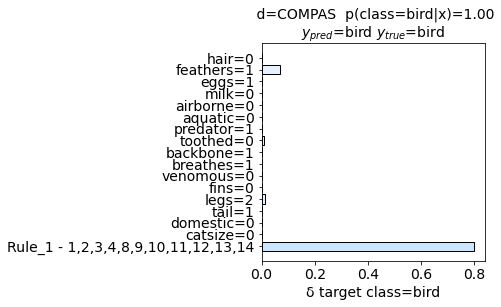

In [18]:
for id_i in correct_prediction[0:1]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=True, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{pc.class_names[predicted_class]}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
    changes=explanation_fm.estimateSingleAttributeChangePrediction()
    if changes:
        print(changes)

### Mispredicted instances

#### Target: predicted class

{'Rule_1': (['hair=0', 'feathers=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'fins=1', 'legs=0', 'tail=1'], '-->', 'fish')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(hair=0, aquatic=1, feathers=0, airborne=0, toothed=1, backbone=1, fins=1, legs=0, tail=1)",fish,0.389777,13,0.209677,100.0,"1,2,5,6,8,9,12,13,14",-0.076498


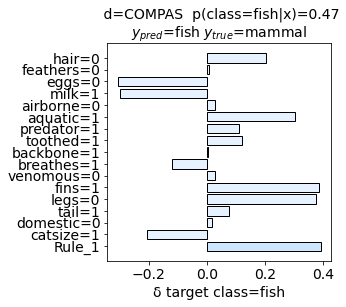

In [19]:
for id_i in mispredicted[-1:]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{pc.class_names[predicted_class]}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    
#     changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)

#### Target: true class

{'Rule_1': (['hair=0', 'feathers=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'fins=1', 'legs=0', 'tail=1'], '-->', 'fish')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(hair=0, aquatic=1, feathers=0, airborne=0, toothed=1, backbone=1, fins=1, legs=0, tail=1)",fish,-0.116202,13,0.209677,100.0,"1,2,5,6,8,9,12,13,14",0.158879


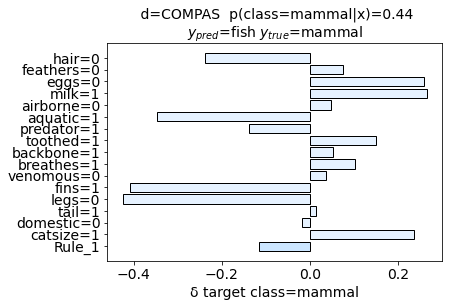

In [20]:
for id_i in mispredicted[-1:]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        "mammal",
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    

### User defined rules

In [21]:
print(explanation_fm.estimateUserRule([ 8, 9], "mammal"))
print(explanation_fm.estimateUserRule([8], "mammal"))
print(explanation_fm.estimateUserRule([9], "mammal"))

{'8,9': 0.15345490830120784}
{'8': 0.15046880652919165}
{'9': 0.053073806406698565}


### What if analysis 

Users can select the attributes of interest, tweak the values and observe how the prediction and explanation change

In [22]:
explanation_fm.interactiveAttributeLevelInspectionExp("mammal")

SelectMultiple(description='Feature', options=('hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'pre…

Button(description='Select attributes', style=ButtonStyle())

### Save results.

Only for visualization/output purposes

{'Rule_1': (['feathers=0', 'eggs=0', 'milk=1', 'toothed=1', 'backbone=1', 'breathes=1', 'venomous=0', 'fins=0'], '-->', 'mammal')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(venomous=0, fins=0, milk=1, breathes=1, feathers=0, toothed=1, backbone=1, eggs=0)",mammal,0.599942,27,0.613636,100.0,"2,3,4,8,9,10,11,12",-0.000039


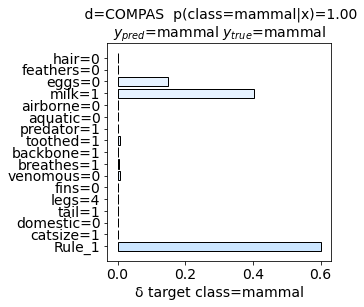

In [23]:
from copy import deepcopy
inst1 = deepcopy(explanation_fm.instance)
encoders=explanation_fm.LACE_explainer_o.train_dataset._column_encoders
lace_explainer=explanation_fm.LACE_explainer_o

feature_names = []
attributes = lace_explainer.train_dataset.attributes()
continuos_features = lace_explainer.train_dataset.continuos_attributes
for f in [v[0] for v in attributes]:
    feature_names.append(f)
targetClass="mammal"
inst1["aquatic"] = "0"    
inst1["legs"] = "4"
inst1["fins"] = "0"

from src.utils_analysis import encodeInstance, DiscretizeInstance

instance_en = encodeInstance(inst1, encoders)
instance_discr = DiscretizeInstance(
    inst1[feature_names], continuos_features, dataset_name=dataset_name
)

lace_explanation = lace_explainer.explain_instance(
    instance_en,
    targetClass,
    featureMasking=True,
    discretizedInstance=instance_discr,
    verbose=False,
)
fig_lace=lace_explanation.plotExplanation(showRuleKey=False, retFig=True)
display(lace_explanation.local_rules.getDataframeRule())
if saveFig:
    fig_name=f"what_if_lace_{classifier_name}_{targetClass}"
    saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)


{'Rule_1': (['hair=0', 'fins=1'], '-->', 'fish')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(fins=1, hair=0)",fish,0.389743,13,0.191176,100.0,"1,12",-0.076464


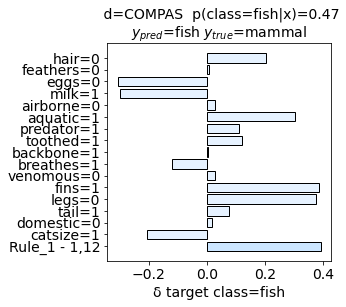

In [24]:
for id_i in mispredicted[-1:]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=False,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=True, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    #explanation_fm.local_rules.printLocalRules()
    if saveFig:
        saveFigure(fig_lace, outputDirResults, id_i, "lace", w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
#     changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)

{'Rule_1': (['hair=0', 'feathers=0', 'airborne=0', 'aquatic=1', 'toothed=1', 'backbone=1', 'fins=1', 'legs=0', 'tail=1'], '-->', 'fish')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(hair=0, aquatic=1, feathers=0, airborne=0, toothed=1, backbone=1, fins=1, legs=0, tail=1)",fish,-0.116202,13,0.191176,100.0,"1,2,5,6,8,9,12,13,14",0.158879


({'hair=0': {'hair=1': 'mammal', 'feathers=1': 'reptile', 'airborne=1': 'reptile', 'aquatic=0': 'mammal', 'predator=0': 'mammal', 'toothed=0': 'reptile', 'backbone=0': 'reptile', 'venomous=1': 'reptile', 'fins=0': 'mammal', 'legs=2': 'mammal', 'legs=4': 'mammal', 'legs=5': 'mammal', 'legs=6': 'mammal', 'legs=8': 'mammal', 'tail=0': 'amphibian', 'domestic=1': 'mammal'}, 'aquatic=1': {'hair=1': 'mammal', 'feathers=1': 'reptile', 'airborne=1': 'reptile', 'aquatic=0': 'mammal', 'predator=0': 'mammal', 'toothed=0': 'reptile', 'backbone=0': 'reptile', 'venomous=1': 'reptile', 'fins=0': 'mammal', 'legs=2': 'mammal', 'legs=4': 'mammal', 'legs=5': 'mammal', 'legs=6': 'mammal', 'legs=8': 'mammal', 'tail=0': 'amphibian', 'domestic=1': 'mammal'}, 'predator=1': {'hair=1': 'mammal', 'feathers=1': 'reptile', 'airborne=1': 'reptile', 'aquatic=0': 'mammal', 'predator=0': 'mammal', 'toothed=0': 'reptile', 'backbone=0': 'reptile', 'venomous=1': 'reptile', 'fins=0': 'mammal', 'legs=2': 'mammal', 'legs=4':

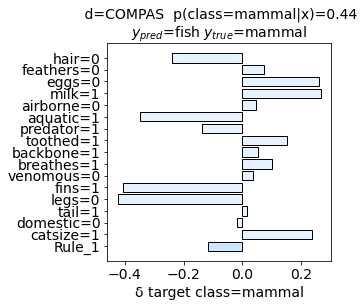

In [25]:
for id_i in mispredicted[-1:]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    target_class="mammal"
    explanation_fm = lace_explainer.explain_instance(
        instance,
        target_class,
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{target_class}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
    changes=explanation_fm.estimateSingleAttributeChangePrediction()
    if changes:
        print(changes)

### Global

In [26]:
n_to_explain=len(pc.d_explain)
global_exp=lace_explainer.computeGlobalExplanation(pc.d_explain, n_to_explain=n_to_explain)

In [27]:
#In case of problems of visualization of lattice graph with jupyter notebook 
import plotly.io as pio
pio.renderers.default="notebook"

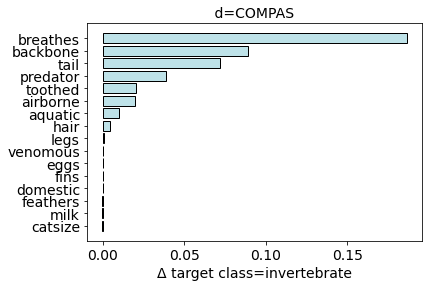

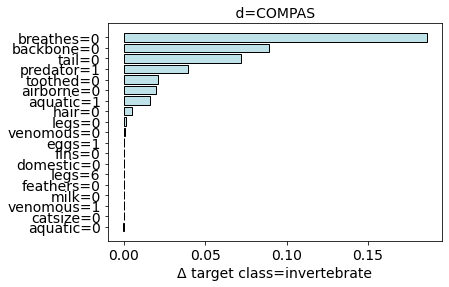

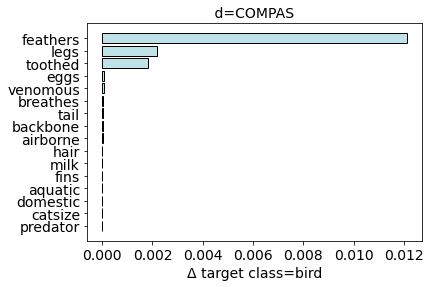

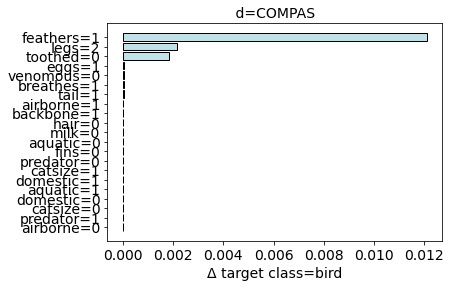

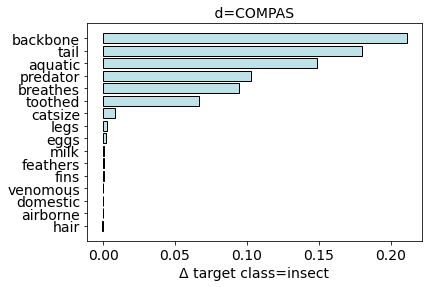

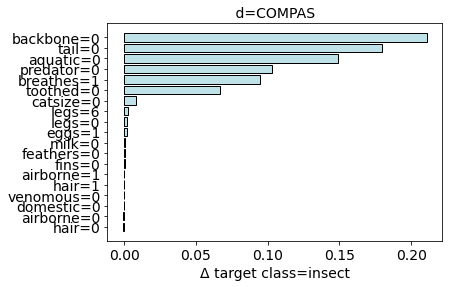

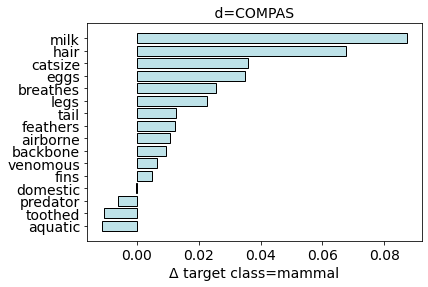

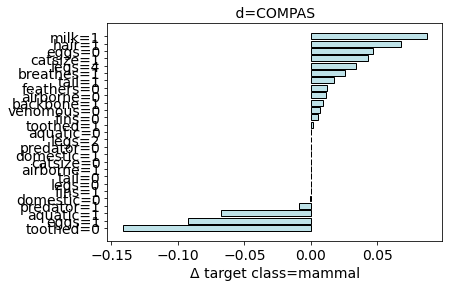

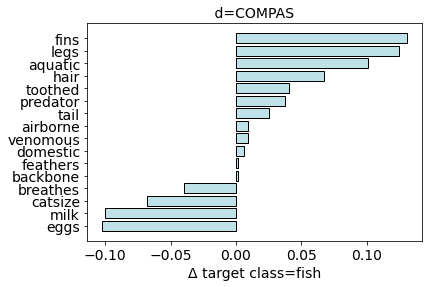

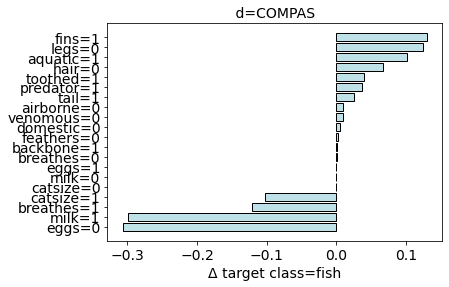

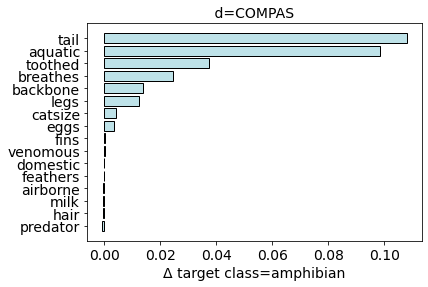

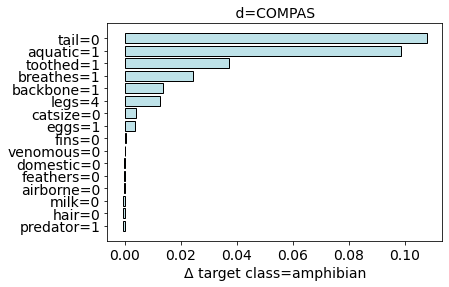

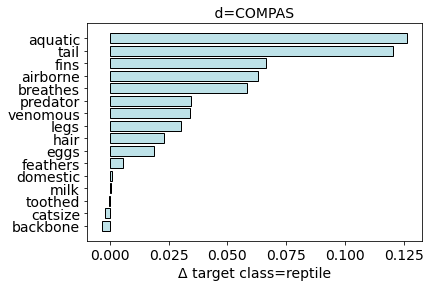

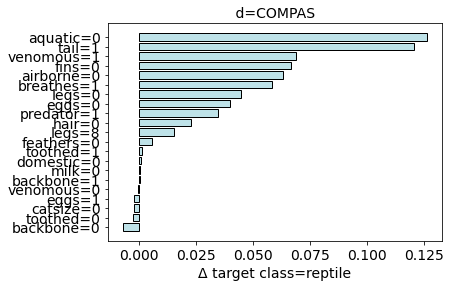

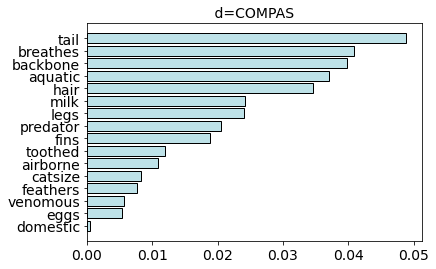

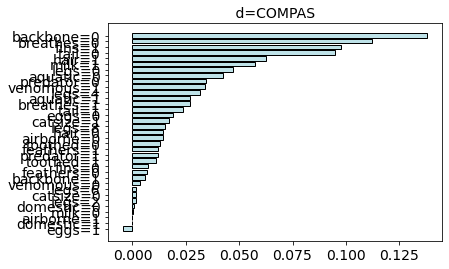

In [28]:
target_class="mammal"

for target_class in global_exp.global_expl_attribute.keys():
    for expl_type in ["attr", "attr_value"]:#,"rules"]:
        fig=global_exp.plotGlobalExplanation(expl_type, interactive=False,target_class=target_class, sortedF=True)
        fig.show()

{'Rule_1': 'hair=0, aquatic=1, feathers=0, airborne=0, toothed=1, backbone=1, fins=1, legs=0, tail=1'}
{'Rule_1': 'venomous=0, milk=1, breathes=1, feathers=0, toothed=1, backbone=1, hair=1, eggs=0', 'Rule_2': 'venomous=0, milk=1, breathes=1, feathers=0, backbone=1, hair=1'}


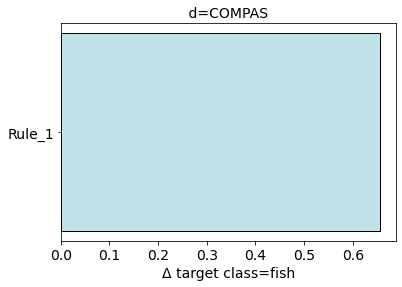

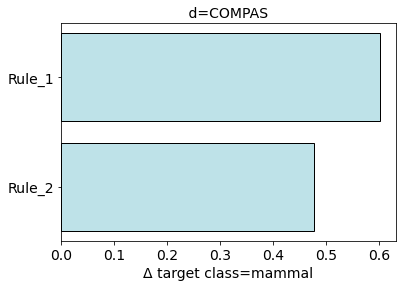

In [29]:
target_class="mammal"


for target_class in ["fish", "mammal"]:
    for expl_type in ["rules"]:
        fig=global_exp.plotGlobalExplanation(expl_type, interactive=False,target_class=target_class, sortedF=True)
        fig.show()

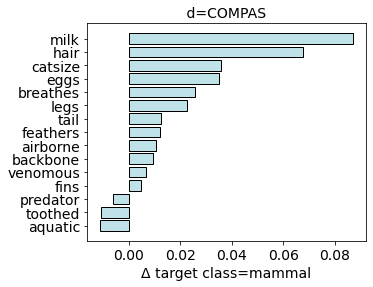

In [31]:
target_class="mammal"
info="attr"
fig=global_exp.plotGlobalExplanation_v2(info, interactive=False,target_class=target_class, sortedF=True, firstK=15)
saveFigure(fig, results_output, f"{info}_{target_class}", explainer_name="lace_global", w=5,h=4)

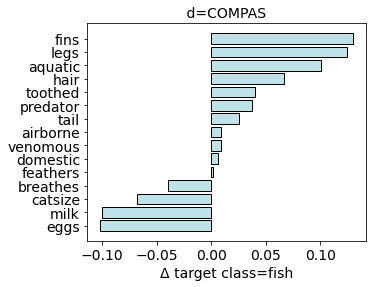

In [32]:
target_class="fish"
info="attr"
fig=global_exp.plotGlobalExplanation_v2( info, interactive=False,target_class=target_class, sortedF=True, firstK=15)
saveFigure(fig, results_output, f"{info}_{target_class}", explainer_name="lace_global", w=5,h=4)

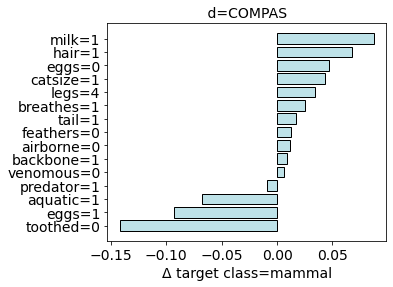

In [33]:
target_class="mammal"
info="attr_value"
fig=global_exp.plotGlobalExplanation_v2(info, interactive=False,target_class=target_class, sortedF=True, firstK=15)
saveFigure(fig, results_output, f"{info}_{target_class}", explainer_name="lace_global", w=5,h=4)

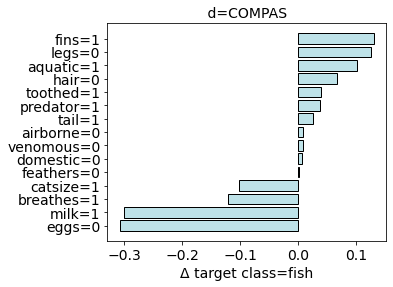

In [34]:
target_class="fish"
info="attr_value"
fig=global_exp.plotGlobalExplanation_v2(info, interactive=False,target_class=target_class, sortedF=True, firstK=15)
saveFigure(fig, results_output, f"{info}_{target_class}", explainer_name="lace_global", w=5,h=4)

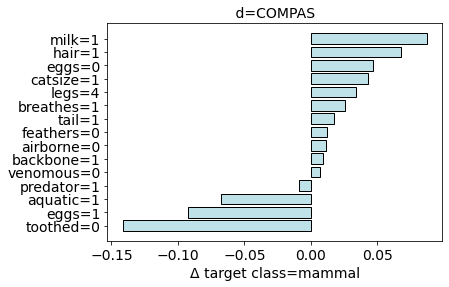

In [35]:
global_expl_res_s=global_exp.plotGlobalExplanation_v2("attr_value", interactive=False,target_class="mammal", sortedF=True, firstK=15)

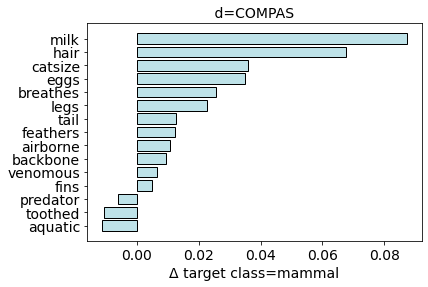

In [36]:
global_expl_res_s=global_exp.plotGlobalExplanation_v2("attr", interactive=False,target_class="mammal", sortedF=True, firstK=15)

In [38]:
# global_expl_res_sorted= {
#                     k: v
#                     for k, v in sorted(
#                         global_expl_res_s.items(),
#                         key=lambda item: abs(item[1]),
#                         reverse=True,
#                     )
#                 }


# RF

In [39]:
from ProcessedDataset_v2 import ProcessedDatasetTrainTest

In [40]:
classifier_name="RF"

In [41]:
outputDirResults=f"./{results_output}/{dataset_name}/{classifier_name}/"
saveResults=True

if saveResults:
    from src.utils import saveJson
    from pathlib import Path
    Path(outputDirResults).mkdir(parents=True, exist_ok=True)

In [42]:
meta_col="name"
pc = ProcessedDatasetTrainTest(df_train, df_test, meta_col=meta_col)

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf_init = RandomForestClassifier(random_state=42)

In [44]:
pc.processTrainTestDataset(clf_init, dataset_name=dataset_name)

In [45]:
predicted=np.argmax(pc.predict_fn(pc.test.values), axis=1)
FP=[i for i,p in enumerate(predicted) if p==1 and pc.labels_test[i]==0]
FN=[i for i,p in enumerate(predicted) if p==0 and pc.labels_test[i]==1]
mispredicted=[i for i,p in enumerate(predicted) if p!=pc.labels_test[i]]
correct_prediction=[i for i,p in enumerate(predicted) if p==pc.labels_test[i]]

In [47]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted),4))

Accuracy:  0.9032


In [48]:
df_test.iloc[mispredicted]

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class,name
99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,invertebrate,worm
81,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,invertebrate,slug
72,0,0,0,0,0,0,1,0,0,1,1,0,8,1,0,0,invertebrate,scorpion


## LACE

In [49]:
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train,pc.predict_fn, dataset_name="COMPAS")

14
{'Rule_1': (['feathers=0', 'eggs=0', 'milk=1', 'toothed=1', 'backbone=1', 'breathes=1', 'venomous=0'], '-->', 'mammal')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(venomous=0, milk=1, breathes=1, feathers=0, toothed=1, backbone=1, eggs=0)",mammal,0.463857,29,0.426471,100.0,"2,3,4,8,9,10,11",-0.063857


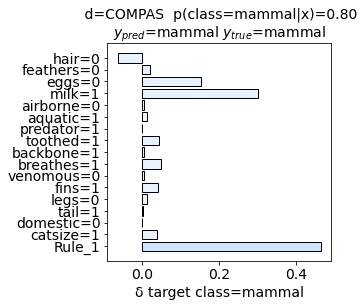

In [51]:
for id_i in [14]:
    print(id_i)
    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{pc.class_names[predicted_class]}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
#     changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)

{'Rule_1': (['milk=1'], '-->', 'mammal')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,(milk=1),mammal,0.3,29,0.426471,100.0,4,0.1


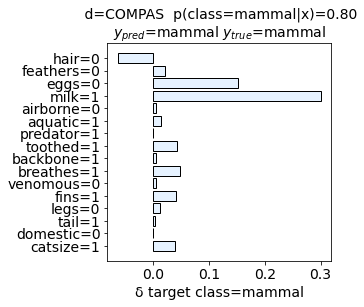

In [53]:
for id_i in [14]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=False,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=True, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{pc.class_names[predicted_class]}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
#     changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)

{'Rule_1': (['feathers=0', 'eggs=0', 'milk=1', 'toothed=1', 'backbone=1', 'breathes=1', 'venomous=0'], '-->', 'mammal')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(venomous=0, milk=1, breathes=1, feathers=0, toothed=1, backbone=1, eggs=0)",mammal,0.542857,29,0.426471,100.0,"2,3,4,8,9,10,11",0.057143


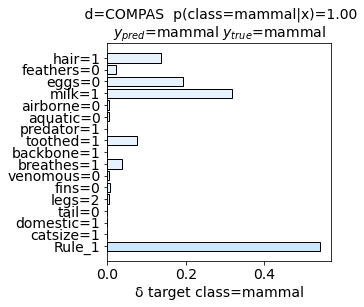

In [54]:
for id_i in [1]:

    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{pc.class_names[predicted_class]}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
#     changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)

In [60]:
explanation_fm.estimateUserRule([2,3,4,8,9,10,11], "mammal")

{'2,3,4,8,9,10,11': 0.5428571428571429}

# NN

In [61]:
from ProcessedDataset_v2 import ProcessedDatasetTrainTest

In [62]:
classifier_name="NN"

In [63]:
outputDirResults=f"./{results_output}/{dataset_name}/{classifier_name}/"
saveResults=True

if saveResults:
    from src.utils import saveJson
    from pathlib import Path
    Path(outputDirResults).mkdir(parents=True, exist_ok=True)

In [64]:
meta_col="name"
pc = ProcessedDatasetTrainTest(df_train, df_test, meta_col=meta_col)

In [72]:
if classifier_name == "RF":

    from sklearn.ensemble import RandomForestClassifier

    clf_init = RandomForestClassifier(random_state=42)

elif classifier_name == "NN":

    from sklearn.neural_network import MLPClassifier

    clf_init = MLPClassifier(random_state=True)

elif classifier_name == "NB":

    from sklearn.naive_bayes import MultinomialNB, CategoricalNB, BernoulliNB, ComplementNB, GaussianNB

    clf_init = MultinomialNB(fit_prior=True)
    clf_init = CategoricalNB()
elif classifier_name=="KNN":
    from sklearn.neighbors import KNeighborsClassifier
    clf_init=KNeighborsClassifier()

elif classifier_name=="SVM":
    from sklearn.svm import SVC
    clf_init=SVC(probability=True)
elif classifier_name=="LR":
    from sklearn.linear_model import LogisticRegression
    clf_init=LogisticRegression(random_state=42)
else:
    raise ValueError()

In [66]:
pc.processTrainTestDataset(clf_init, dataset_name=dataset_name)

In [67]:
predicted=np.argmax(pc.predict_fn(pc.test.values), axis=1)
FP=[i for i,p in enumerate(predicted) if p==1 and pc.labels_test[i]==0]
FN=[i for i,p in enumerate(predicted) if p==0 and pc.labels_test[i]==1]
mispredicted=[i for i,p in enumerate(predicted) if p!=pc.labels_test[i]]
correct_prediction=[i for i,p in enumerate(predicted) if p==pc.labels_test[i]]

In [68]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted),4))

Accuracy:  0.9032


In [69]:
df_test.iloc[mispredicted]

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class,name
99,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,invertebrate,worm
81,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,invertebrate,slug
72,0,0,0,0,0,0,1,0,0,1,1,0,8,1,0,0,invertebrate,scorpion


## LACE

In [70]:
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train,pc.predict_fn, dataset_name="COMPAS")

14
{'Rule_1': (['feathers=0', 'eggs=0', 'milk=1', 'toothed=1', 'backbone=1', 'breathes=1', 'venomous=0'], '-->', 'mammal')}


,rule,rule_class,prediction_difference,support_count,support,confidence,rule_id,eps_error
0,"(venomous=0, milk=1, breathes=1, feathers=0, toothed=1, backbone=1, eggs=0)",mammal,0.553548,28,0.538462,100.0,"2,3,4,8,9,10,11",-0.013806


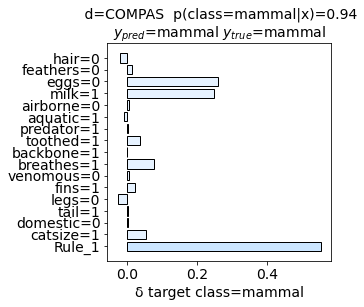

In [71]:
for id_i in [14]:
    print(id_i)
    
    predicted_class=pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1,-1))[0]
    
    featureMasking=True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        specialistic_rules=True,
        verbose=False)
    fig_lace =explanation_fm.plotExplanation(showRuleKey=False, retFig=True, fontsize=fontsize)
    display(explanation_fm.local_rules.getDataframeRule())
    if saveFig:
        fig_name=f"lace_{classifier_name}_{pc.class_names[predicted_class]}"
        saveFigure(fig_lace, outputDirResults, id_i, fig_name, w=4,h=4)
    prediction_difference_attr=explanation_fm.getPredictionDifferenceDict()#{attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}

    

    
#     changes=explanation_fm.estimateSingleAttributeChangePrediction()
#     if changes:
#         print(changes)